<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

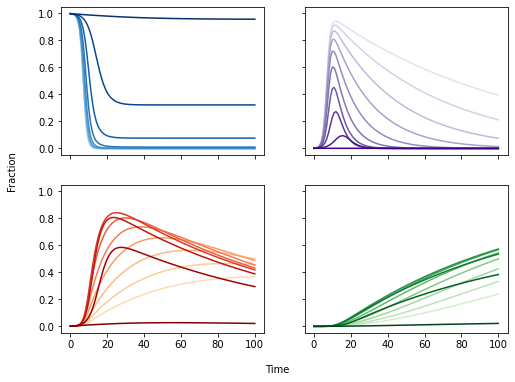

In [2]:
import sys
sys.path.append('../')
from sir.ode_seir import ode_simulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import itertools as it
import matplotlib.ticker as mticker




# global hyper parameters
N = 1000 # 1000 is enough for ode to generate smooth lines
T = 100
e0 = i0 = 0.001
b, k = 1, 0.01
f = 0.2

# check how s,e,i,r change with f
def plot_lines(ax, df, cmap=mpl.cm.OrRd, start=0.2, end=1):
    """
    plot simulated result with various value of f
    input
        df: shape (len(fs),T), every row is, e.g. i(t), for certain f
        cmap: a matplot.cm colormap object, see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
        start, end: scale location in color map
    """
    cols = [cmap(x) for x in np.linspace(start, end, len(df))]
    for i, col in enumerate(cols):
        ax.plot(df[i,:], c=col)
    # ax.set_xlabel('Time')
    # ax.set_ylabel('Fraction')
    return ax

    # # add colorbar
    # divider = make_axes_locatable(plt.gca())
    # ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    # cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=cmap, orientation='vertical')
    # plt.gcf().add_axes(ax_cb)

def plot_f_effect(fs, T=T, b=b, f=f, k=k, save_as=None):
    result = [] # (fs, T, seir)
    for f in fs:
        seirs = ode_simulation(e0, i0, T=T, b=b, f=f, k=k)
        result.append(seirs)

    result = np.asarray(result)
    result.shape

    fig, ax = plt.subplots(2,2, figsize=(8,6), sharex='all', sharey='all')
    ax[0,0] = plot_lines(ax[0,0], result[:,:,0], mpl.cm.Blues)
    ax[0,1] = plot_lines(ax[0,1], result[:,:,1], mpl.cm.Purples)
    ax[1,0] = plot_lines(ax[1,0], result[:,:,2], mpl.cm.OrRd)
    ax[1,1] = plot_lines(ax[1,1], result[:,:,3], mpl.cm.Greens)
    fig.text(0.5, 0.04, 'Time', va='center', ha='center')
    fig.text(0.04, 0.5, 'Fraction', va='center', ha='center', rotation='vertical')
    if save_as:
        plt.savefig(f'../output/{save_as}.png', dpi=300)

fs = np.logspace(-2,0,10)
plot_f_effect(fs, save_as='ode_seir_by_f')



# 3-D Phase diagram in PDF
def simulate_bfks(bs, ks, fs, T=T, N=N, e0=e0, i0=i0):
    """
    return
        bfks: (bs*ks*fs, 3)
        itss: (bs*ks*fs, T), record of i(t) for every (b,f,k) setting
    """
    bfks0 = []
    itss0 = []

    for b,f,k in it.product(bs, fs, ks):
        seirs = ode_simulation(e0=e0, i0=i0, T=T, b=b, f=f, k=k)
        its = seirs[:, 2] # i(t)
        bfks0.append([b,f,k])
        itss0.append(its)

    bfks = np.asarray(bfks0).reshape(len(itss0), 3)
    itss = np.asarray(itss0) # nsim * (T+1)
    return bfks, itss

def log_tick_formatter(val, pos=None):
    return "{:.2f}".format(np.exp(val))

def plot_phase_2d(bfks, its, cmap='OrRd', title=None, save_as=None):
    """
    plot a 2-D phase diagram of i(t) for varying b, f, k
    input:
        bfks: combination of bs, fs, ks, shape=(bs*ks*fs, 3)
        its: i(t) for combinations b, f, k, shape=(len(bfks), )
    """
    bs, fs, ks = (np.unique(bfks[:, i]) for i in range(3))
    its2 = its.reshape(len(bs), len(fs), len(ks))
    f, ax = plt.subplots(1, 3, figsize=(15,4))

    ax[0].imshow(its2.mean(axis=0).transpose()[::-1,:], aspect='auto',
                 extent=[np.min(np.log(fs)), np.max(np.log(fs)), np.min(np.log(ks)), np.max(np.log(ks))],
                 vmin=0, vmax=1, cmap=cmap)
    ax[0].set_xlabel(r'$f$: infected fraction')
    ax[0].xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax[0].set_ylabel(r'$k$: recover fraction')
    ax[0].yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))

    ax[1].imshow(its2.mean(axis=1).transpose()[::-1,:], aspect='auto',
                 extent=[np.min(bs), np.max(bs), np.min(np.log(ks)), np.max(np.log(ks))],
                 vmin=0, vmax=1, cmap=cmap)
    ax[1].set_xlabel(r'$b$: number of interactions')
    ax[1].set_ylabel(r'$k$: recover fraction')
    ax[1].yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))

    ax[2].imshow(its2.mean(axis=2)[::-1,:], aspect='auto',
                 extent=[np.min(np.log(fs)), np.max(np.log(fs)), np.min(bs), np.max(bs)],
                 vmin=0, vmax=1, cmap=cmap)
    ax[2].set_xlabel(r'$f$: infected fraction')
    ax[2].xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax[2].set_ylabel(r'$b$: number of interactions')

    # f.colorbar(ax[2], ax=[ax[0],ax[1],ax[2]])

    plt.subplots_adjust(wspace = 0.3)

    if title:
        f.text(0.5, 0.99, title, ha='center', fontsize=14)
    if save_as:
        plt.savefig(f'../docs/figs/{save_as}.png', dpi=300)


def plot_phase_3d(bfks, its, cmap='OrRd', title=None, save_as=None):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scat = ax.scatter3D(bfks[:,0], np.log(bfks[:,1]), np.log(bfks[:,2]),
                        c=its, cmap=cmap, vmin=0, vmax=1, alpha=0.2, linewidths=0)

    ax.set_xlabel('b')
    ax.set_ylabel('f')
    ax.set_zlabel('k')

    ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    fig.colorbar(scat, pad=0.2, shrink=0.8)
    if title:
        plt.title(title)
        
    plt.rcParams['savefig.dpi'] = 300
    if save_as:
        plt.savefig(f'../docs/figs/{save_as}.png', dpi=300)




In [ ]:
grid_size = 20
bs = np.arange(grid_size)+1
ks = np.logspace(-2,-0.5,grid_size) # larger ks has no effect
fs = np.logspace(-2,0,grid_size)
T = 100
bfks, itss = simulate_bfks(bs, ks, fs, T=100)

# try plot when t=50
t = 50
# plot_phase_2d(bfks, itss[:,t], title=f't = {t}', save_as='ode_seir_phase_2d')
# plot_phase_3d(bfks, itss[:,t], title=f't = {t}', save_as='ode_seir_phase_3d')




In [13]:

def plot_phase_3d(bfks, its, cmap='OrRd', title=None, save_as=None):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scat = ax.scatter3D(bfks[:,0], np.log(bfks[:,1]), np.log(bfks[:,2]),
                        c=its, cmap=cmap, vmin=0, vmax=1, alpha=0.2, linewidths=0)

    ax.set_xlabel('b')
    ax.set_ylabel('f')
    ax.set_zlabel('k')

    ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    fig.colorbar(scat, pad=0.2, shrink=0.8)
    if title:
        plt.title(title)
        
    plt.rcParams['figure.dpi'] = 300
    if save_as:
        plt.savefig(f'../docs/figs/{save_as}.pdf', dpi=300)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


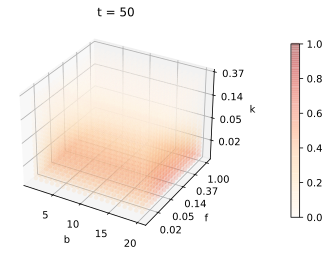

In [14]:
t = 50
# plot_phase_2d(bfks, itss[:,t], title=f't = {t}', save_as='ode_seir_phase_2d')
plot_phase_3d(bfks, itss[:,t], title=f't = {t}', save_as='ode_seir_phase_3d')




In [ ]:
# plot along time
for t in range(T//2+1):
    plot_phase_2d(bfks, itss[:,t], title=f't = {t}')
    plt.show()

for t in range(T+1):
    plot_phase_3d(bfks, itss[:,t], title=f't = {t}')
    plt.show()

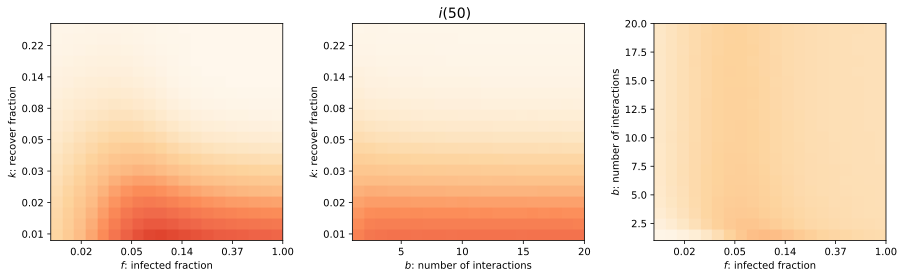

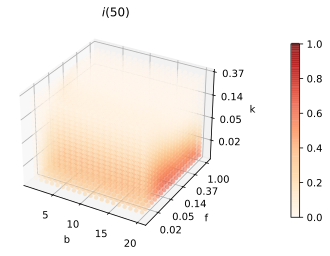

In [15]:
#
import sys
sys.path.append('../sir')
from agent_seir import PopulationSEIR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import itertools as it
import matplotlib.ticker as mticker

# global hyper parameters
N = 10000
T = 100
e0 = i0 = 0.001
b, k = 1, 0.01
f = 0.2


# check how s,e,i,r change with f
def plot_lines(ax, df, cmap=mpl.cm.OrRd, start=0.2, end=1, title=None):
    """
    plot simulated result with various value of f
    input
        df: shape (len(fs),T), every row is, e.g. i(t), for certain f
        cmap: a matplot.cm colormap object, see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
        start, end: scale location in color map
    """
    cols = [cmap(x) for x in np.linspace(start, end, len(df))]
    for i, col in enumerate(cols):
        ax.plot(df[i,:], c=col)

    if title:
        ax.set_title(title)
    # ax.set_xlabel('Time')
    # ax.set_ylabel('Fraction')
    return ax

    # # add colorbar
    # divider = make_axes_locatable(plt.gca())
    # ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    # cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=cmap, orientation='vertical')
    # plt.gcf().add_axes(ax_cb)

def plot_f_effect(fs, T=T, b=b, f=f, k=k, save_as=None):
    result = [] # (fs, T, seir)
    for f in fs:
        pop = PopulationSEIR(N, e0, i0)
        seirs = pop.simulation(T=T, b=b, f=f, k=k)
        result.append(seirs)

    result = np.asarray(result)
    result.shape

    fig, ax = plt.subplots(2,2, figsize=(8,6), sharex='all', sharey='all')
    ax[0,0] = plot_lines(ax[0,0], result[:,:,0], mpl.cm.Blues)
    ax[0,1] = plot_lines(ax[0,1], result[:,:,1], mpl.cm.Purples)
    ax[1,0] = plot_lines(ax[1,0], result[:,:,2], mpl.cm.OrRd)
    ax[1,1] = plot_lines(ax[1,1], result[:,:,3], mpl.cm.Greens)
    fig.text(0.5, 0.04, 'Time', va='center', ha='center')
    fig.text(0.04, 0.5, 'Fraction', va='center', ha='center', rotation='vertical')
    if save_as:
        plt.savefig(f'../docs/figs/{save_as}.png', dpi=300)

fs = np.logspace(-2,0,10)
plot_f_effect(fs, save_as='ode_seir_by_f')

# 3-D Phase diagram in PDF
def simulate_bfks(bs, ks, fs, T=T, N=N, e0=e0, i0=i0):
    """
    return
        bfks: (bs*ks*fs, 3)
        itss: (bs*ks*fs, T), record of i(t) for every (b,f,k) setting
    """
    bfks0 = []
    itss0 = []

    for b,f,k in it.product(bs, fs, ks):
        pop = PopulationSEIR(N, e0, i0)
        seirs = pop.simulation(T=T, b=b, f=f, k=k)
        its = seirs[:, 2] # i(t)
        bfks0.append([b,f,k])
        itss0.append(its)

    bfks = np.asarray(bfks0).reshape(len(itss0), 3)
    itss = np.asarray(itss0) # nsim * (T+1)
    return bfks, itss


def log_tick_formatter(val, pos=None):
    return "{:.2f}".format(np.exp(val))

def plot_phase_2d(bfks, its, cmap='OrRd', title=None, save_as=None):
    """
    plot a 2-D phase diagram of i(t) for varying b, f, k
    input:
        bfks: combination of bs, fs, ks, shape=(bs*ks*fs, 3)
        its: i(t) for combinations b, f, k, shape=(len(bfks), )
    """
    bs, fs, ks = (np.unique(bfks[:, i]) for i in range(3))
    its2 = its.reshape(len(bs), len(fs), len(ks))
    f, ax = plt.subplots(1, 3, figsize=(15,4))

    ax[0].imshow(its2.mean(axis=0).transpose()[::-1,:], aspect='auto',
                 extent=[np.min(np.log(fs)), np.max(np.log(fs)), np.min(np.log(ks)), np.max(np.log(ks))],
                 vmin=0, vmax=1, cmap=cmap)
    ax[0].set_xlabel(r'$f$: infected fraction')
    ax[0].xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax[0].set_ylabel(r'$k$: recover fraction')
    ax[0].yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))

    ax[1].imshow(its2.mean(axis=1).transpose()[::-1,:], aspect='auto',
                 extent=[np.min(bs), np.max(bs), np.min(np.log(ks)), np.max(np.log(ks))],
                 vmin=0, vmax=1, cmap=cmap)
    ax[1].set_xlabel(r'$b$: number of interactions')
    ax[1].set_ylabel(r'$k$: recover fraction')
    ax[1].yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))

    ax[2].imshow(its2.mean(axis=2)[::-1,:], aspect='auto',
                 extent=[np.min(np.log(fs)), np.max(np.log(fs)), np.min(bs), np.max(bs)],
                 vmin=0, vmax=1, cmap=cmap)
    ax[2].set_xlabel(r'$f$: infected fraction')
    ax[2].xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax[2].set_ylabel(r'$b$: number of interactions')

    plt.subplots_adjust(wspace = 0.3)
    if title:
        f.text(0.5, 0.90, title, ha='center', fontsize=14)
    if save_as:
        plt.savefig(f'../docs/figs/{save_as}.png', dpi=300)


def plot_phase_3d(bfks, its, cmap='OrRd', title=None, save_as=None):
    """
    plot a 3-D phase diagram of i(t) for varying b, f, k
    input:
        bfks: combination of bs, fs, ks, shape=(bs*ks*fs, 3)
        its: i(t) for combinations b, f, k, shape=(len(bfks), )
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scat = ax.scatter3D(bfks[:,0], np.log(bfks[:,1]), np.log(bfks[:,2]),
                        c=its, cmap=cmap, vmin=0, vmax=1, alpha=0.5, linewidths=0)

    ax.set_xlabel('b')
    ax.set_ylabel('f')
    ax.set_zlabel('k')
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    fig.colorbar(scat, pad=0.2, shrink=0.8)
    if title:
        plt.title(title)
    if save_as:
        plt.savefig(f'../docs/figs/{save_as}.png', dpi=300)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
grid_size = 20
bs = np.arange(grid_size)+1
ks = np.logspace(-2,-0.5, grid_size)
fs = np.logspace(-2,0, grid_size)
T = 100
bfks, itss = simulate_bfks(bs, ks, fs, T=100)
t = 50
plot_phase_2d(bfks, itss[:,t], title=f'$i({t})$')
plot_phase_3d(bfks, itss[:,t], title=f'$i({t})$')


# for t in range(T+1):
#     plot_phase_2d(bfks, itss[:,t], title=f't = {t}')
#     plt.show()
#
#
# for t in range(T+1):
#     plot_phase_3d(bfks, itss[:,t], title=f't = {t}')
#     plt.show()
